# Authors : Jose Luis Ruanova Lea, Rodrigo Gónzalez Linares

# Preparations

## Check if GPU avaliable

In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

2023-03-19 21:52:08.079293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 21:52:08.124501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 21:52:08.125438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 21:52:08.126324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-19 21:52:08.127021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

True

## If using Google Collab

You may want to run some code cells of this section if you are using google collab to run this notebook. Following cell mounts your google drive into the collab enviroment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Collab is based on a Linux enviroment, so normal bash commands can be executed. For this notebook, I upload the dataset zip file into a folder in my drive called datasets .

In [ ]:
%cd /content/drive/MyDrive/datasets/
!ls

In [ ]:
!unzip oracle_CV.zip

# Processing the data

For this first approach, I splitted the data into train and validation and read the test data for later use (to generate the evaluable JSON file). The split size chosen was 20% of the training data, with a random state to replicate results. To improve results, image augmentation was performed, by rotating, rescaling, shifting...etc the images to increase the number of them and help the algorithm to generalize. Batch size selected was 32.

In [48]:
# libraries needed 
import pandas as pd
import keras
import numpy as np
import sklearn

In [200]:
# reading the datasets
train_data = pd.read_csv('train.csv')
train_data['label'] = train_data['label'].astype(str) # convert labels to string values
test_data = pd.read_csv('test.csv')

# getting validation set
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [184]:
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255, # normalizing pixel values
        rotation_range=20,     
        width_shift_range=0.2, 
        height_shift_range=0.2,
        shear_range=0.2,       
        zoom_range=0.2,        
        horizontal_flip=True,  
        fill_mode='nearest')  

test_datagen = ImageDataGenerator(rescale=1./255) 

# training data generator
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="path_img",
        y_col="label",
        target_size=(100, 100), 
        batch_size=32,
        class_mode='categorical') 

# validation data generator
val_generator = train_datagen.flow_from_dataframe(
        dataframe=val_data,
        x_col="path_img",
        y_col="label",
        target_size=(100, 100), 
        batch_size=32,
        class_mode='categorical')

# test data generator
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col="path_img",
        y_col=None,
        target_size=(100, 100),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 8951 validated image filenames belonging to 8 classes.
Found 2238 validated image filenames belonging to 8 classes.
Found 4797 validated image filenames.


# Simple first model

On this first model, a very simple architecture built using the Sequential class. 

- Input feature map has a shape of 100x100 with 3 color channels (depth). 
- Input is processed with a combination of Conv2D layers with increasing number of filters and MaxPooling layers to reduce dimensionality. 
- For Conv2D layers, a fixed kernel size of 3 was used and ReLu as activation function (only positive values).
- At last, a Flatten() layer output is sended to an output Dense layer with 8 neuron to learn the threshold to classify on the 8 classes, following a softmax activation function mapping.
- For this first approach, no regularization techniques had been applied.

Also, in this approach and in the next ones, a early stopping callback was added to stop the training when loss in validation doesnt improve after a certain number of epochs.

In [185]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(254, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(8, activation='softmax'))


In [186]:
from tensorflow.keras.optimizers import *

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=val_generator,
                   callbacks=[early_stopping])

Epoch 1/50
202/280 [====================>.........] - ETA: 4s - loss: 2.0057 - acc: 0.1958

/home/mia1/anaconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


280/280 [==============================] - 19s 69ms/step - loss: 1.9841 - acc: 0.2110 - val_loss: 1.9112 - val_acc: 0.2632
Epoch 2/50
280/280 [==============================] - 19s 69ms/step - loss: 1.8721 - acc: 0.2799 - val_loss: 1.7708 - val_acc: 0.3409
Epoch 3/50
280/280 [==============================] - 19s 69ms/step - loss: 1.7232 - acc: 0.3593 - val_loss: 1.6370 - val_acc: 0.4097
Epoch 4/50
280/280 [==============================] - 19s 69ms/step - loss: 1.5761 - acc: 0.4287 - val_loss: 1.5161 - val_acc: 0.4786
Epoch 5/50
280/280 [==============================] - 20s 70ms/step - loss: 1.4573 - acc: 0.4806 - val_loss: 1.3951 - val_acc: 0.5103
Epoch 6/50
280/280 [==============================] - 20s 70ms/step - loss: 1.4014 - acc: 0.5049 - val_loss: 1.3434 - val_acc: 0.5255
Epoch 7/50
280/280 [==============================] - 20s 70ms/step - loss: 1.2994 - acc: 0.5487 - val_loss: 1.3891 - val_acc: 0.5335
Epoch 8/50
280/280 [==============================] - 20s 70ms/step - los

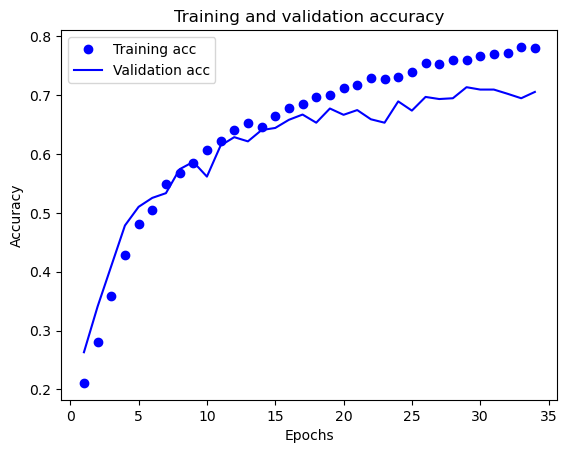

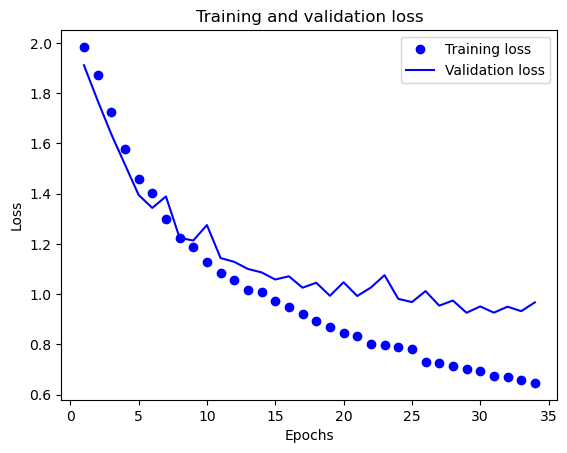

In [187]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


While the results are not bad and validation error is near to training one, it seems to be near its limit starting to converge, so looking for better results and as far as transfer learning is valid for this task, lets check well-known models in order to improve the performance.

# VGG19 transfer learning

First I try just adding a Conv2D layer with a 3x3 kernel size and a Dense layer with a dropout of 0.5 on top of the VGG19 model, before the output layer, and see how it works. Just to note, the output layer of VGG19 was removed to fit our specific requirements. 

In [189]:
from tensorflow.keras.applications import VGG19
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)
model = Model(inputs=vgg_model.input, outputs=predictions)

In [190]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator,
                   callbacks=[early_stopping])

Epoch 1/30
280/280 [==============================] - 20s 70ms/step - loss: 1.6409 - acc: 0.3996 - val_loss: 1.2979 - val_acc: 0.5447
Epoch 2/30
280/280 [==============================] - 19s 70ms/step - loss: 1.3286 - acc: 0.5336 - val_loss: 1.2399 - val_acc: 0.5853
Epoch 3/30
280/280 [==============================] - 19s 69ms/step - loss: 1.2525 - acc: 0.5679 - val_loss: 1.2044 - val_acc: 0.5925
Epoch 4/30
280/280 [==============================] - 20s 70ms/step - loss: 1.1930 - acc: 0.5905 - val_loss: 1.2151 - val_acc: 0.5715
Epoch 5/30
280/280 [==============================] - 19s 69ms/step - loss: 1.1629 - acc: 0.6037 - val_loss: 1.1655 - val_acc: 0.6014
Epoch 6/30
280/280 [==============================] - 19s 70ms/step - loss: 1.1480 - acc: 0.6081 - val_loss: 1.1641 - val_acc: 0.6019
Epoch 7/30
280/280 [==============================] - 20s 70ms/step - loss: 1.1048 - acc: 0.6235 - val_loss: 1.0982 - val_acc: 0.6273
Epoch 8/30
280/280 [==============================] - 20s 70ms

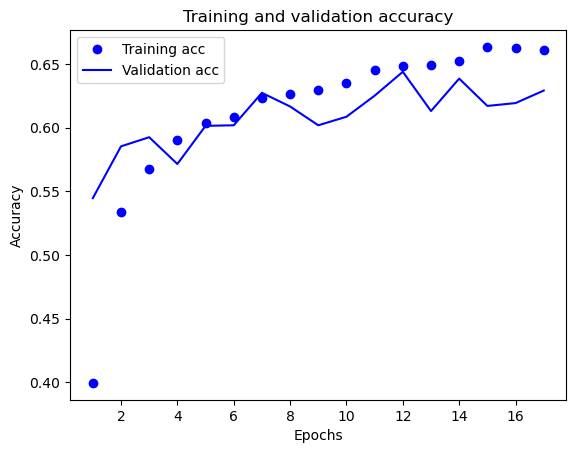

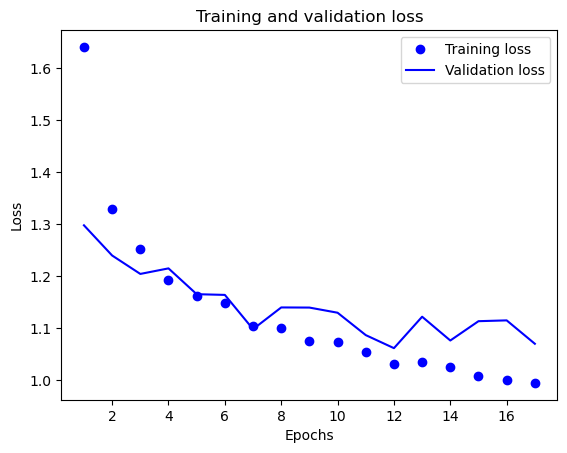

In [192]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The results didnt convince us, so here we tried to modify the architecture by training again the last convolutional block of the VGG-19 model, adding just a dense layer (with corresponding dropout to reduce overfitting) on the top of the model. The rest of the code remains the same.

In [193]:
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=predictions)

for layer in model.layers[-6:]:
    layer.trainable = True
    
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=val_generator,
                   callbacks=[early_stopping])

Epoch 1/50
280/280 [==============================] - 20s 70ms/step - loss: 1.5227 - acc: 0.4716 - val_loss: 1.2360 - val_acc: 0.5693
Epoch 2/50
280/280 [==============================] - 19s 68ms/step - loss: 1.2209 - acc: 0.5971 - val_loss: 1.1614 - val_acc: 0.6104
Epoch 3/50
280/280 [==============================] - 19s 69ms/step - loss: 1.1334 - acc: 0.6261 - val_loss: 1.1166 - val_acc: 0.6260
Epoch 4/50
280/280 [==============================] - 19s 69ms/step - loss: 1.0704 - acc: 0.6424 - val_loss: 1.0863 - val_acc: 0.6550
Epoch 5/50
280/280 [==============================] - 19s 70ms/step - loss: 1.0141 - acc: 0.6662 - val_loss: 1.1021 - val_acc: 0.6363
Epoch 6/50
280/280 [==============================] - 20s 70ms/step - loss: 0.9711 - acc: 0.6747 - val_loss: 1.0286 - val_acc: 0.6676
Epoch 7/50
280/280 [==============================] - 19s 70ms/step - loss: 0.9603 - acc: 0.6787 - val_loss: 1.0034 - val_acc: 0.6685
Epoch 8/50
280/280 [==============================] - 19s 69ms

As far as the results are not as good as with the simple models, without further experimentation, other models to do transfer learning with were proved.

# ResNet50 models

Here instead of VGG19 we use ResNet50, adding a global average pooling layer followed by three dense layers with decreasing number of neurons and corresponding dropout layers on the top of the model. Also, last 10 layers were trained again and another optimizer was used instead of Adam, the stochastic gradient descent optimizer, with a learning rate of $10^-4$ and a momentum of 0.9.  

In [197]:
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  
x = Dense(512, activation='relu')(x) 
x = Dropout(0.5)(x)  
x = Dense(254, activation='relu')(x) 

predictions = Dense(8, activation='softmax')(x)

for layer in base_model.layers[-10:]:  
    layer.trainable = True

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = SGD(lr=0.001, momentum=0.9)  

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=32,
                    validation_data=val_generator,
                   callbacks=[early_stopping])



Epoch 1/50
280/280 [==============================] - 22s 72ms/step - loss: 1.6542 - accuracy: 0.4011 - val_loss: 2.1847 - val_accuracy: 0.1430
Epoch 2/50
280/280 [==============================] - 20s 71ms/step - loss: 0.9425 - accuracy: 0.6969 - val_loss: 2.2404 - val_accuracy: 0.1273
Epoch 3/50
280/280 [==============================] - 20s 72ms/step - loss: 0.7240 - accuracy: 0.7738 - val_loss: 1.3398 - val_accuracy: 0.5366
Epoch 4/50
280/280 [==============================] - 20s 73ms/step - loss: 0.6253 - accuracy: 0.8047 - val_loss: 0.6160 - val_accuracy: 0.8070
Epoch 5/50
280/280 [==============================] - 21s 74ms/step - loss: 0.5592 - accuracy: 0.8261 - val_loss: 0.5849 - val_accuracy: 0.8235
Epoch 6/50
280/280 [==============================] - 20s 73ms/step - loss: 0.5082 - accuracy: 0.8407 - val_loss: 0.5686 - val_accuracy: 0.8338
Epoch 7/50
280/280 [==============================] - 21s 74ms/step - loss: 0.4620 - accuracy: 0.8513 - val_loss: 0.5354 - val_accuracy:

In [198]:
model.save('second.h5')

/home/mia1/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [199]:
import json
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('second.h5')

predictions = model.predict(test_generator)
pred_labels = np.argmax(predictions, axis=1)

results = {}
for i, label in enumerate(pred_labels):
    results[str(test_data.iloc[i]['idx_test'])] = int(label)

output = {"target": results}

with open('predictions.json', 'w') as file:
    json.dump(output, file)


Results are pretty good, so we save this model just in case and lets try to train it again with a large image size to know if it works better that way:

In [203]:
# last try increasing image size to 224x224 (the ResNet50 original image size)
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255, # normalize pixel values
        rotation_range=20,     
        width_shift_range=0.2, 
        height_shift_range=0.2,
        shear_range=0.2,       
        zoom_range=0.2,        
        horizontal_flip=True,  
        fill_mode='nearest')  

test_datagen = ImageDataGenerator(rescale=1./255) 

# training data generator
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="path_img",
        y_col="label",
        target_size=(224, 224), 
        batch_size=32,
        class_mode='categorical') 

# validation data generator
val_generator = train_datagen.flow_from_dataframe(
        dataframe=val_data,
        x_col="path_img",
        y_col="label",
        target_size=(224, 224), 
        batch_size=32,
        class_mode='categorical')

# test data generator
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        x_col="path_img",
        y_col=None,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 8951 validated image filenames belonging to 8 classes.
Found 2238 validated image filenames belonging to 8 classes.
Found 4797 validated image filenames.


In [204]:
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  
x = Dense(512, activation='relu')(x) 
x = Dropout(0.5)(x)  
x = Dense(254, activation='relu')(x) 

predictions = Dense(8, activation='softmax')(x)

for layer in base_model.layers[-10:]:  
    layer.trainable = True

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = SGD(lr=0.001, momentum=0.9)  

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=32,
                    validation_data=val_generator,
                   callbacks=[early_stopping])



/home/mia1/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
 85/280 [========>.....................] - ETA: 31s - loss: 2.0724 - accuracy: 0.2221

/home/mia1/anaconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


280/280 [==============================] - 61s 208ms/step - loss: 1.3725 - accuracy: 0.5173 - val_loss: 3.4658 - val_accuracy: 0.1224
Epoch 2/50
280/280 [==============================] - 57s 205ms/step - loss: 0.5894 - accuracy: 0.8227 - val_loss: 1.8803 - val_accuracy: 0.3320
Epoch 3/50
280/280 [==============================] - 59s 209ms/step - loss: 0.4455 - accuracy: 0.8667 - val_loss: 0.6004 - val_accuracy: 0.7994
Epoch 4/50
280/280 [==============================] - 59s 210ms/step - loss: 0.3706 - accuracy: 0.8872 - val_loss: 0.5016 - val_accuracy: 0.8400
Epoch 5/50
280/280 [==============================] - 58s 208ms/step - loss: 0.3240 - accuracy: 0.9018 - val_loss: 0.3718 - val_accuracy: 0.9035
Epoch 6/50
280/280 [==============================] - 60s 216ms/step - loss: 0.2650 - accuracy: 0.9197 - val_loss: 0.3754 - val_accuracy: 0.8923
Epoch 7/50
280/280 [==============================] - 59s 211ms/step - loss: 0.2353 - accuracy: 0.9284 - val_loss: 0.3359 - val_accuracy: 0.9

In [205]:
model.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_51[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

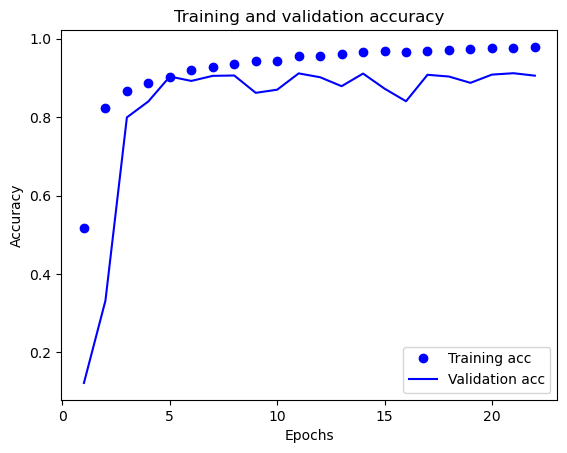

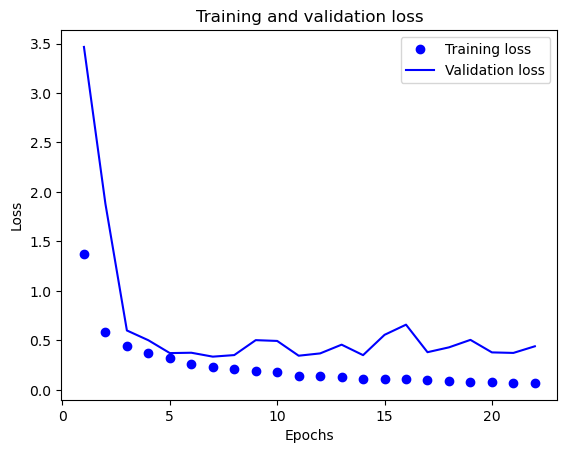

In [207]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [208]:
model.save('final.h5')

/home/mia1/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [210]:
import json
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('final.h5')

predictions = model.predict(test_generator)
pred_labels = np.argmax(predictions, axis=1)

results = {}
for i, label in enumerate(pred_labels):
    results[str(test_data.iloc[i]['idx_test'])] = int(label)

output = {"target": results}

with open('predictions.json', 'w') as file:
    json.dump(output, file)


This was, of course, the better model of all of the trained ones. So we selected this last one to deliver, saving the model and saving the results in the JSON format required.